# This is wildfire Remote Sensing image data project. I used Convolution Neural Network to train the model to predict the wild fire from the large set of images.

## Dipak P Duall
### University of Alabama at Birmingham, Department of Mathematics

In [ ]:
# import drive and connect with drive

from google.colab import drive
drive.mount('/content/drive/')

# New Section

In [ ]:
#!pip install -q keras

This project is related to prediction of wildfire using wildfire satellite images

# 1. Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.utils import load_img,img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout,BatchNormalization,Conv2D,MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os 
from tensorflow.keras.optimizers import legacy as optimizers


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed May 10 16:13:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Get the list of physical devices (CPUs and GPUs) available to TensorFlow
physical_devices = tf.config.list_physical_devices('GPU') 

# If there is at least one GPU available, set it as the visible device for TensorFlow
if len(physical_devices) > 0:
    tf.config.set_visible_devices(physical_devices[0], 'GPU')
    print('GPU is set as the visible device.')
else:
    print('No GPUs are available.')

GPU is set as the visible device.


# 2. Data Extraction and Rescaling

In [ ]:

#train_path = '/content/drive/MyDrive/wild_fire_data/train'
#test_path = '/content/drive/MyDrive/wild_fire_data/test'
#val_path = '/content/drive/MyDrive/wild_fire_data/valid'

In [ ]:
import zipfile

In [ ]:
zip_file = '/content/drive/MyDrive/archive_wildfire.zip'
with zipfile.ZipFile(zip_file,'r') as zip_ref:
  zip_ref.extractall('/content')
train_path = '/content/train'
test_path = '/content/test'
val_path = '/content/valid'

In [ ]:
image_shape = (300,300,3)
N_CLASSES = 2
BATCH_SIZE = 256

# loading training data and rescaling it using ImageDataGenerator
train_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255., rotation_range= 40,width_shift_range=0.2,zoom_range=0.2,vertical_flip= True,horizontal_flip= True,shear_range= 0.07)
train_generator = train_datagen.flow_from_directory(train_path,
                                                    batch_size = BATCH_SIZE,
                                                    target_size = (300,300),
                                                    class_mode = 'categorical',
                                                    seed = 42,
                                                    shuffle = True,
                                                    subset = 'training'
                                          
                                                    )
train_datagen.fit(train_generator[0][0])
# loading validation data and rescaling it using ImageDataGenerator
val_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255., rotation_range= 40,width_shift_range=0.2,zoom_range=0.2,vertical_flip= True,horizontal_flip= True,shear_range= 0.07)
val_generator = val_datagen.flow_from_directory(val_path,
                                                batch_size = BATCH_SIZE,
                                                target_size = (300,300),
                                                class_mode = 'categorical',
                                                seed = 42,
                                                shuffle = True
                                                )
val_datagen.fit(val_generator[0][0])

# loading test data and rescaling it using ImageDataGenerator
test_datagen = ImageDataGenerator(dtype='float32', rescale = 1.0/255.0,rotation_range = 40)
test_generator = test_datagen.flow_from_directory(test_path,
                                                  batch_size = BATCH_SIZE,
                                                  target_size = (300,300),
                                                  class_mode = 'categorical',
                                                  seed = 42,
                                                  shuffle = False,
                                                  )

Found 30250 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.


# Building Model

In [ ]:
# defining the coefficient that our regularizer
weight_decay = 1e-3

# building a sequential CNN model and adding layers to it
# dropout and the regularizer are used in general to prevent overfitting
first_model = Sequential([
    Conv2D(filters = 8 , kernel_size = 2, activation = 'relu', 
    input_shape = image_shape), MaxPooling2D(pool_size = 2),
    
    Conv2D(filters = 16 , kernel_size = 2, activation = 'relu'),
    MaxPooling2D(pool_size = 2),
    Conv2D(filters = 32 , kernel_size = 2, activation = 'relu'),
    MaxPooling2D(pool_size = 2),
   Conv2D(filters = 64 , kernel_size = 2, activation = 'relu',
          kernel_regularizer = regularizers.l2(weight_decay)),
    MaxPooling2D(pool_size = 2), 
    Dropout(0.2),
    Flatten(),
    Dense(300,activation='relu'),
    Dropout(0.4),
    Dense(2,activation='softmax')
])
# showing the summary of our model (layers and number of parameters)
first_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 299, 299, 8)       104       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 148, 148, 16)      528       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 73, 73, 32)        2080      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 36, 36, 32)       0

# Training Model

In [11]:
 # don't stop everything if an image didn't load correctly
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# checkpointer to save the model only if it improved
checkpointer = ModelCheckpoint('first_model.hdf5',verbose=1, save_best_only= True)
# early stopping to stop the training if our validation loss didn't decrease for (10) consecutive epochs
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 8)
# Adam, best optimiser for deep learning models to help with the training
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-5)
# setting our loss function and which metric to evaluate
first_model.compile(loss= 'categorical_crossentropy', optimizer= optimizer,
                    metrics=['AUC','acc'])

# TRAIN
history = first_model.fit(train_generator,
                    epochs = 40,
                    verbose = 1,
                    validation_data = val_generator,
                    callbacks = [checkpointer, early_stopping])

Epoch 1/40
119/119 [==============================] - ETA: 0s - loss: 0.6354 - auc: 0.8075 - acc: 0.6807
Epoch 1: val_loss improved from inf to 0.51027, saving model to first_model.hdf5
119/119 [==============================] - 747s 6s/step - loss: 0.6354 - auc: 0.8075 - acc: 0.6807 - val_loss: 0.5103 - val_auc: 0.9539 - val_acc: 0.8767
Epoch 2/40
119/119 [==============================] - ETA: 0s - loss: 0.4204 - auc: 0.9495 - acc: 0.8820
Epoch 2: val_loss improved from 0.51027 to 0.33330, saving model to first_model.hdf5
119/119 [==============================] - 720s 6s/step - loss: 0.4204 - auc: 0.9495 - acc: 0.8820 - val_loss: 0.3333 - val_auc: 0.9664 - val_acc: 0.9025
Epoch 3/40
119/119 [==============================] - ETA: 0s - loss: 0.3246 - auc: 0.9574 - acc: 0.8920
Epoch 3: val_loss improved from 0.33330 to 0.29158, saving model to first_model.hdf5
119/119 [==============================] - 726s 6s/step - loss: 0.3246 - auc: 0.9574 - acc: 0.8920 - val_loss: 0.2916 - val_au

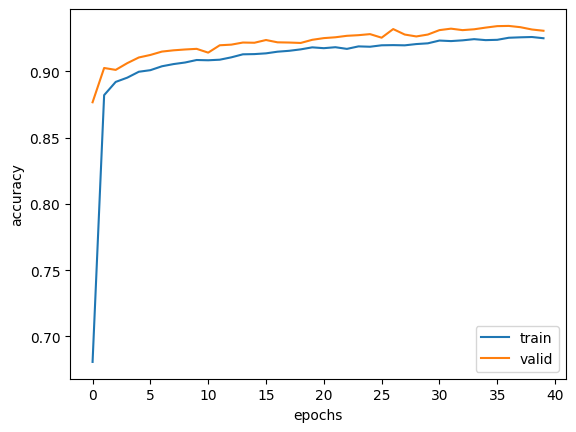

In [12]:
# add history of accuracy and validation accuracy to the plot
plt.plot(history.history['acc'], label = 'train',)
plt.plot(history.history['val_acc'], label = 'valid')

# adding legend and labels
plt.legend(loc = 'lower right')
plt.xlabel('epochs')
plt.ylabel('accuracy')

# show the plot
plt.show()